## Using LSTMs to Predict Mid-Price Movement from the Limit Order Book

- The goal of this notebook is to predict whether the mid-price will decrease, stay the same, or increase during the next tick. This is accomplished through the usage of an LSTM in tensorflow.

### Import the necessary packages

In [1]:
%matplotlib inline
from ml_analysis import MLOperator, MLEvaluator, get_LSTM_data
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import time
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.metrics import f1_score

### Prepare the data

In [2]:
#read dataset (dataset should include features and label)
df = pd.read_csv('all_features_new.csv')
df = df.dropna()

#split train and test dataset
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df[:split]
df_test = df[split:]

operator = MLOperator()
n_steps = 5 #length of the sequence
use_features = list(df.columns[:-1])
y_train = df_train.label

#resampling to get a balanced label set
sampled_idx = operator.get_samples_index(y_train.iloc[n_steps-1:], 'min')
x_train = df_train[use_features]
y_test = df_test.label.iloc[n_steps-1:]
x_test = df_test[use_features]
x_train, y_train, x_test, y_test = get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps)

#normalization
x_max = np.max(x_train,axis=0)
x_min = np.min(x_train,axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

#select first 3000 rows in test set as validation set
nrow = 3000
x_valid = x_test[0:nrow]
y_valid = y_test[0:nrow]
x_test = x_test[nrow:]
y_test = y_test[nrow:]
#print (x_train.shape,y_train.shape,x_test.shape,y_test.shape, x_valid.shape, y_valid.shape)

### Set the parameters

In [3]:
# Training Parameters
learning_rate = 0.0001
keep_prob = 0.5 #1 - dropout rate
lambd = 0 #penalty parameter 
n_epoch = 5000
n_batch = 700
display_step = 100

# Network Parameters
num_input = x_train.shape[-1] # number of features
timesteps = n_steps # timesteps
num_hidden = 10 # hidden layer num of features
num_classes = 3 # up, down and no-movement
num_layers = 2 # number of hidden layers

# tf Graph input
# the input variables are first define as placeholder
# a placeholder is a variable/data which will be assigned later
X = tf.placeholder("float", [None, timesteps, num_input]) #dim: batch_size, number of time steps, number of inputs
Y = tf.placeholder("float", [None, num_classes])#dim:batch_size, number of classes (10 here)

#initialize the weigths with a normal random law initialization

weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

### Define the RNN

In [4]:
def RNN(x, weights, biases):
    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # 1-layer LSTM with num_hidden units
    #rnn_cell = rnn.BasicLSTMCell(num_hidden,activation=tf.nn.sigmoid)
    #rnn_cell = rnn.BasicLSTMCell(num_hidden)
    
    # 2-layer LSTM, each layer has num_hidden units. And you can wrap more layers together by doing list comprehension.
    #rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(num_hidden),rnn.BasicLSTMCell(num_hidden)])
    
    rnn_cell = rnn.MultiRNNCell([rnn.DropoutWrapper(rnn.LSTMCell(num_hidden), output_keep_prob=keep_prob) for _ in range(num_layers)])
    
    # Get rnn cell output
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # (1) Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


### Define the loss and optimzation

In [5]:
logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)
#define the loss 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
# add L2 regularization too all weights
l2 = lambd * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
loss_op = loss_op + l2

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#tf.equal: Returns the truth value of (x == y) element-wise.
#tf.cast: Casts a tensor to a new type. --- here it casts from boolean to float
#tf.argmax:Returns the index with the largest value across axes of a tensor. --- here along the axis of the vector

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

### Run the model

In [6]:
# Start training
with tf.Session() as sess:
    
    start_time = time.time()
    
    #please, make sure you changed for your own path 
    #log_files_path = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'
    log_files_path = 'C:/Users/yelin0618/logs/'
    
    #save and restore variables to and from checkpoints.
    saver = tf.train.Saver()

    # Run the initializer
    sess.run(init)
    
    #will work with this later
    #saver.restore(sess, log_files_path+'multi_layer/model-checkpoint-66000')
    
    loss_trace = []
    
    num_examples = x_train.shape[0]

    # Training cycle
    for epoch in range(n_epoch):
        
        avg_cost = 0.
        total_batch = int(num_examples/n_batch)
        
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]
                    
        # Loop over all batches
        for i in range(total_batch):
            
            minibatch_x, minibatch_y = x_train[i*n_batch:(i+1)*n_batch], y_train[i*n_batch:(i+1)*n_batch]

            #minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
            
            # Fit training using batch data
            #the training is done using the training dataset
            sess.run(train_op, feed_dict={X: minibatch_x, Y: minibatch_y})
            # Compute average loss
            avg_cost += sess.run(loss_op, feed_dict={X: minibatch_x, Y: minibatch_y})/total_batch
        
        # Display logs per epoch step
        if epoch % display_step == 0:
                    
            #the accuracy is evaluated using the validation dataset
            train_acc = sess.run(accuracy, feed_dict={X: x_train, Y: y_train})
            val_cost = sess.run(loss_op, feed_dict={X: x_valid, Y: y_valid})
            acc = sess.run(accuracy, feed_dict={X: x_valid, Y: y_valid})
            loss_trace.append(1-acc)    
            print("Epoch:", '%04d' % (epoch+1), "train_loss :", "{:0.4f}".format(avg_cost), "train_acc :", "{:0.4f}".format(train_acc), \
                  "val_loss :", "{:0.4f}".format(val_cost), "val_acc :", "{:0.4f}".format(acc))    
    
    #save to use later
    saver.save(sess, log_files_path+'DL_Project/lstm-checkpoint')
    
    print("Optimization Finished!")
    #accuracy evaluated with the whole test dataset
    acc = sess.run(accuracy, feed_dict={X: x_test, Y: y_test})
    print("Test Accuracy:", acc)
                    
    elapsed_time = time.time() - start_time
    print('Execution time (seconds) was %0.3f' % elapsed_time)

Epoch: 0001 train_loss : 1.2323 train_acc : 0.3333 val_loss : 1.4937 val_acc : 0.0027
Epoch: 0101 train_loss : 1.0016 train_acc : 0.4874 val_loss : 0.9876 val_acc : 0.3813
Epoch: 0201 train_loss : 0.8530 train_acc : 0.6305 val_loss : 0.7696 val_acc : 0.6087
Epoch: 0301 train_loss : 0.7469 train_acc : 0.7039 val_loss : 0.5794 val_acc : 0.7197
Epoch: 0401 train_loss : 0.6828 train_acc : 0.7342 val_loss : 0.4992 val_acc : 0.7780
Epoch: 0501 train_loss : 0.6467 train_acc : 0.7406 val_loss : 0.4527 val_acc : 0.7927
Epoch: 0601 train_loss : 0.6153 train_acc : 0.7531 val_loss : 0.4109 val_acc : 0.7970
Epoch: 0701 train_loss : 0.6066 train_acc : 0.7615 val_loss : 0.4033 val_acc : 0.8157
Epoch: 0801 train_loss : 0.6013 train_acc : 0.7634 val_loss : 0.3817 val_acc : 0.8113
Epoch: 0901 train_loss : 0.5837 train_acc : 0.7695 val_loss : 0.3743 val_acc : 0.8240
Epoch: 1001 train_loss : 0.5744 train_acc : 0.7723 val_loss : 0.3574 val_acc : 0.8303
Epoch: 1101 train_loss : 0.5735 train_acc : 0.7762 val

### Evaluate the model

In [7]:
# returns a compiled model
# identical to the previous one
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, log_files_path+'DL_Project/lstm-checkpoint')
    
    pred = sess.run(prediction, feed_dict={X: x_train, Y: y_train})    
    pred_df_train = pd.DataFrame(pred, columns=['-1', '0', '1'])
    pred_df_train['predict'] = pred_df_train.idxmax(axis=1)
    pred_df_train['true'] = pd.DataFrame(y_train, columns=['-1', '0', '1']).idxmax(axis=1)
    
    pred = sess.run(prediction, feed_dict={X: x_test, Y: y_test})    
    pred_df_test = pd.DataFrame(pred, columns=['-1', '0', '1'])
    pred_df_test['predict'] = pred_df_test.idxmax(axis=1)
    pred_df_test['true'] = pd.DataFrame(y_test, columns=['-1', '0', '1']).idxmax(axis=1)  
    
train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)
print (train_f1)
print (test_f1)

INFO:tensorflow:Restoring parameters from C:/Users/yelin0618/logs/DL_Project/lstm-checkpoint
[0.83320343 0.83815029 0.81739812]
[0.0269885  0.87292535 0.02490641]


### Results on training data

Confusion matrix, without normalization
[[1069    5  125]
 [ 144  870  185]
 [ 154    2 1043]]
Normalized confusion matrix
[[0.89157631 0.00417014 0.10425354]
 [0.12010008 0.72560467 0.15429525]
 [0.12844037 0.00166806 0.86989158]]


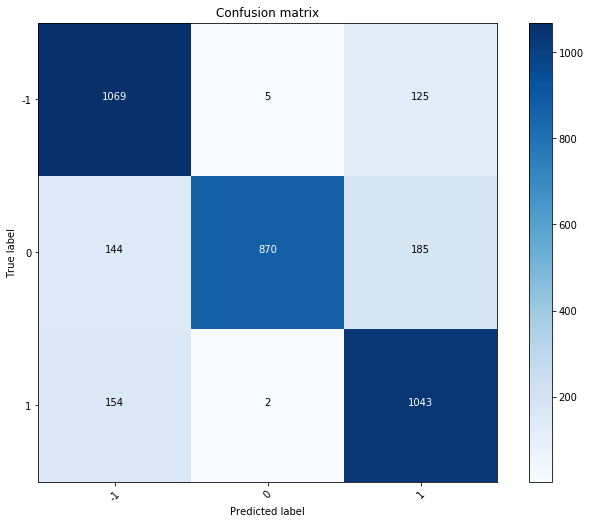

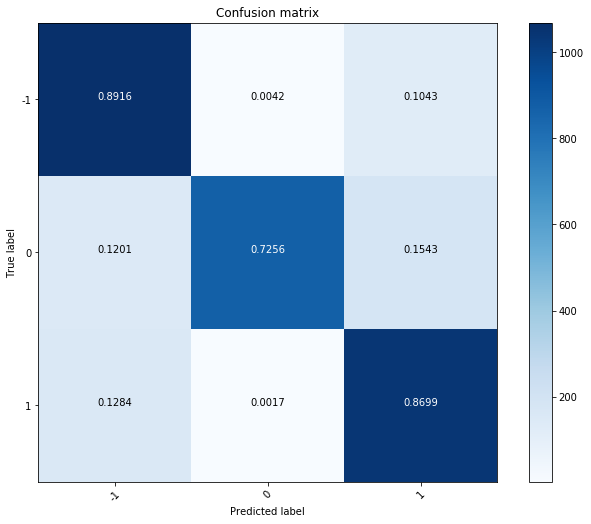

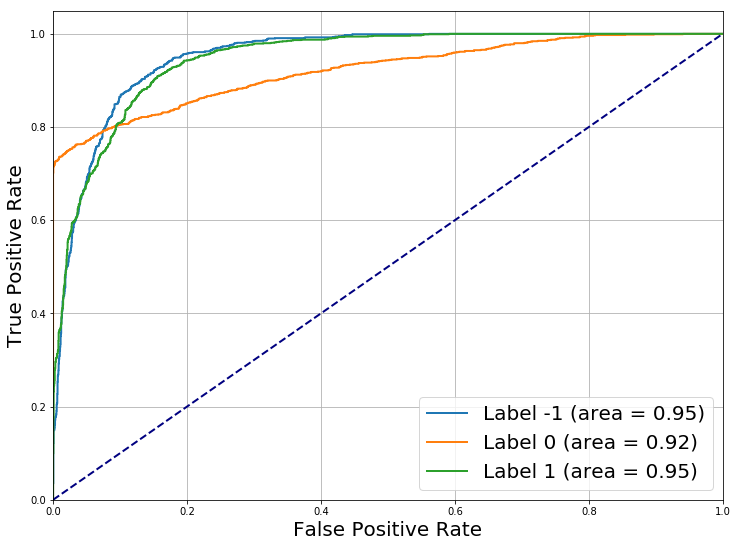

In [8]:
evaluator = MLEvaluator()
evaluator.set_pred_df(pred_df_train)
cf_mx_train = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 0, 1], normalize=True)
fig = evaluator.plot_roc()

### Results on testing data

Confusion matrix, without normalization
[[  142    19    51]
 [10150 78524 12674]
 [   19    19   163]]
Normalized confusion matrix
[[0.66981132 0.08962264 0.24056604]
 [0.10014998 0.77479575 0.12505427]
 [0.09452736 0.09452736 0.81094527]]


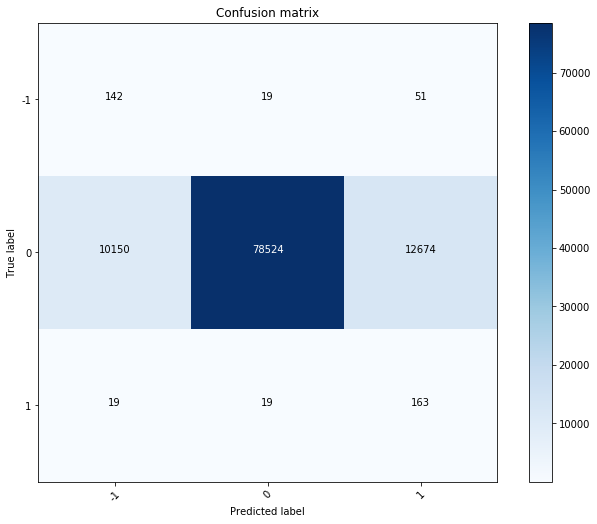

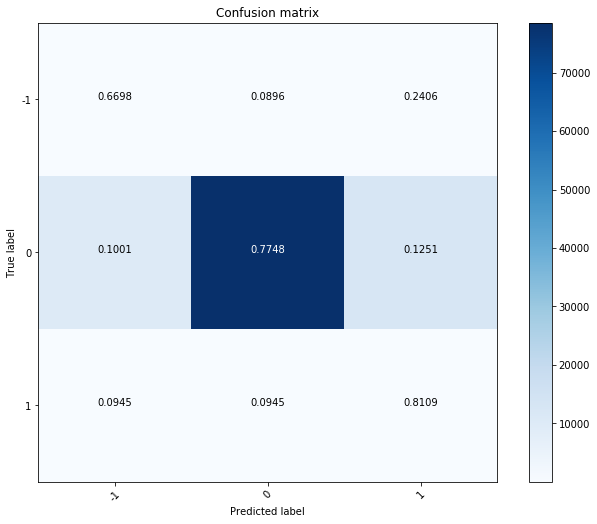

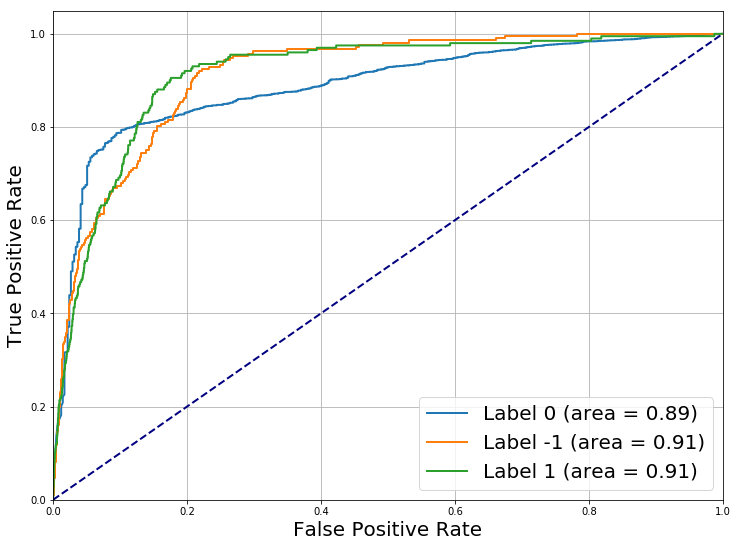

In [9]:
evaluator.set_pred_df(pred_df_test)
cf_mx_test = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 0, 1], normalize=True)
fig = evaluator.plot_roc()